# Building a Classifier for Handwritten Digits
### Image Classification Machine Learning Model

In this project I will try to explore image classification, a popular kind application for machine learning models. 

I am going to apply this in verifying images of handwritten digits and classifying them between 0 and 9. Each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features. it might be the case that images are downsized to lower resolutions, as the resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.

In grayscale (no color), each pixel is just represented as a brightness value ranging from 0 to 256.

To give some contextualization to the problem, before the year 2000, institutions like the United States Post Office used handwriting recognition software to read addresses, zip codes, and more. One of their approaches, which consists of pre-processing handwritten images then feeding to a neural network model is detailed in [this paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.852.5499&rep=rep1&type=pdf).


We will train, test, and improve a few different deep neural networks for image classification, and **explore the effectiveness of deep, feedforward neural networks at classifying images**.

Here is a summary of the steps I will follow in this project:

1. Import Relevant Libraries
2. Display Images
3. Implement K-Nearest Neighbors Model (able to capture nonlinearity)
4. Verify K-Nearest Neighbors Accuracy
5. Implement Neural Network MLPClassifier with single layer
6. Test Different Activation Functions and Numbers of Neurons
7. Compare Accuracy
8. Verify if there is Overfitting
9. Implement Neural Network MLPClassifier with two layers
10. Verify Two Layer Model Accuracy
11. Implement Neural Network MLPClassifier with three layers
12. Verify Three Layer Model Accuracy
13. Implement Decision Trees and Random Forests
14. Look into the Weights
15. Conclusions and Next Steps

Let's get started.


## 1. Import Relevant Libraries


In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

## 2. Display Images

Now, let's load the data and take a look at the images there and start exploring what can be done.

Scikit-learn contains a number of [datasets](https://scikit-learn.org/stable/datasets/index.html) pre-loaded with the library, within the namespace of sklearn.datasets. The load_digits() [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI.

Because dataframes are a tabular representation of data, each image is represented as a row of pixel values. To visualize an image from the dataframe, we need to reshape the image back to its original dimensions (28 x 28 pixels). To visualize the image, we need to reshape these pixel values back into the 28 by 28 and plot them on a coordinate grid.

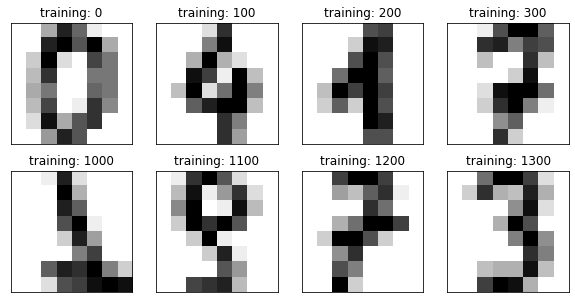

In [2]:
data, target = load_digits(return_X_y = True)
features= pd.DataFrame(data)
target= pd.Series(target)

image_rows= [0,100,200,300,1000,1100,1200,1300]

fig= plt.figure(figsize=(10,5))
n= 0
for r in image_rows:
    image_feature= features.iloc[r]
    np_image= image_feature.values
    np_image= np_image.reshape(8,8)
    ax= fig.add_subplot(2,4,n+1)
    n+= 1
    ax.set_title("training: %i"%r)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(np_image, cmap= "gray_r")
    
plt.show()

## 3. Implement K-Nearest Neighbors 

One of the great advantages of using K-Nearest Neighbors over Linear Regression for example, is that it is able to capture nonlinearity. 

The k-nearest neighbors algorithm compares every unseen observation in the test set to all (or many, as some implementations constrain the search space) training observations to look for similar (or the "nearest") observations. Then, the algorithm finds the label with the most nearby observations and assigns that as the prediction for the unseen observation.

We can use the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) package to train and test k-nearest neighbors models.

I will use the KNeighborsClassifier package to train and test k-nearest neighbors models and cross validate with k-fold set to 4:

In [3]:
#creating the training function
def train(n,train,target):
    knn= KNeighborsClassifier(n_neighbors= n)
    knn.fit(train,target)
    return knn

#creating the testing function
def test(knn,test,target):
    prediction= knn.predict(test)
    return accuracy_score(target,prediction)

#creating the validation function
def cross_validate(n,k,features,target):
    kf = KFold(n_splits= k, random_state=2, shuffle= True)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        knc = train(n, train_features, train_target)
        train_accuracy = test(knc, train_features, train_target)
        test_accuracy = test(knc, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

#spliting the data 
train_features= features[0:int(features.shape[0]*0.8)]
train_target= target[0:int(features.shape[0]*0.8)]
test_features= features[int(features.shape[0]*0.8):]
test_target= target[int(features.shape[0]*0.8):]

#running the cross-validation test with 4-fold
train_accuracies,test_accuracies= cross_validate(5,4,features,target)
mean_train_accuracies= np.mean(train_accuracies)
mean_test_accuracies= np.mean(test_accuracies)
print(mean_train_accuracies,mean_test_accuracies)

0.9897977756923287 0.9849777282850779


## 4. Verify K-Nearest Neighbors Accuracy

Let's take a look at the influence of the number of neighbors adn plot it's accuracy:

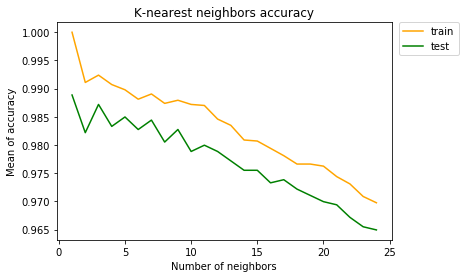

In [4]:
train_mean_accuracies = []
test_mean_accuracies = []
for k in range(1, 25):
    train_accuracies, test_accuracies = cross_validate(k, 4, features, target)
    train_mean_accuracies.append(np.mean(train_accuracies))
    test_mean_accuracies.append(np.mean(test_accuracies))
x = range(1, 25)
y = train_mean_accuracies
plt.plot(x, y, color = 'orange', label = 'train')
y = test_mean_accuracies
plt.plot(x, y, color = 'green', label = 'test')

plt.xlabel('Number of neighbors')
plt.ylabel('Mean of accuracy')
plt.title('K-nearest neighbors accuracy')
plt.legend(bbox_to_anchor=(1.2,1), borderaxespad=0)

Accuracy is at it's maximum when the number of neighbors is 1. It increased again at k = 4 especially in test data set. Increasing the number of neighbors reduces the accuracy with almost the same difference between the accuracy of the train and test data sets.

The main downsides to using k-nearest neighbors are:

- high memory usage (for each new unseen observation, many comparisons need to be made to seen observations)
- no model representation to debug and explore

## 5. Implement Neural Network MLPClassifier with single layer


In [5]:
#creating the training function
def train(n,activate,train,target):
    nn= MLPClassifier(hidden_layer_sizes= (n,), activation= activate,max_iter= 1000)
    nn.fit(train,target)
    return nn

#creating the testing function
def test(nn,test,target):
    prediction= nn.predict(test)
    return accuracy_score(target,prediction)

#creating the validation function
def cross_validate(k,n,activate,features,target):
    kf = KFold(n_splits= k, random_state=2, shuffle= True)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        nn = train(n,activate, train_features, train_target)
        train_accuracy = test(nn, train_features, train_target)
        test_accuracy = test(nn, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

## 6. Test Different Activation Functions and Numbers of Neurons

We will test the [Rectified Linear Unit (ReLU) activation function](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/#:~:text=The%20rectified%20linear%20activation%20function,otherwise%2C%20it%20will%20output%20zero.&text=The%20rectified%20linear%20activation%20function%20overcomes%20the%20vanishing%20gradient%20problem,learn%20faster%20and%20perform%20better.) and the [Hiperbolic Tangent activation function](https://sefiks.com/2017/01/29/hyperbolic-tangent-as-neural-network-activation-function/) for 0 to 300 neurons in one single hidden layer:

[0.9990725626130383, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.9315664439495175, 0.9549331848552339, 0.9632751794110369, 0.9682887899034892, 0.9777493194753775, 0.9771974758723088]


[]

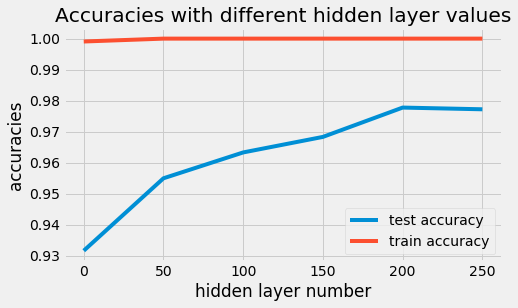

In [6]:
#4-fold cross validation with relu activation function
hidden_layers= [8,16,32,64,128,256]
activate= "relu"
train_accuracies_n= []
test_accuracies_n= []
for hl in hidden_layers:
    train_accuracies,test_accuracies= cross_validate(4,hl,activate,features,target)
    train_accuracies_n.append(np.mean(train_accuracies))
    test_accuracies_n.append(np.mean(test_accuracies))
    
print(train_accuracies_n)
print(test_accuracies_n)

#visualizing
plt.style.use('fivethirtyeight')
x= range(0,300,50)
y_test= test_accuracies_n
y_train= train_accuracies_n
fig,ax= plt.subplots(figsize=(7,4))
ax.plot(x,y_test, label='test accuracy')
ax.plot(x,y_train, label='train accuracy')
ax.set_xlabel("hidden layer number")
ax.set_ylabel("accuracies")
ax.set_title("Accuracies with different hidden layer values")
ax.legend(loc="lower right")
plt.plot()

[0.9946209733025804, 0.9992578848699935, 0.9998144023756496, 1.0, 1.0, 1.0]
[0.9170861172976985, 0.9571566443949518, 0.9638431081415492, 0.9699579312051473, 0.9794172234595397, 0.9799715416975997]


[]

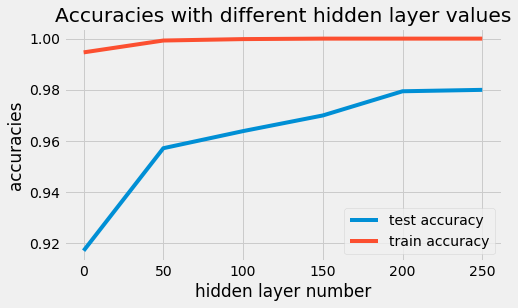

In [7]:
#4-fold cross validation with tanh activation function
activate= "tanh"
train_accuracies_n= []
test_accuracies_n= []
for hl in hidden_layers:
    train_accuracies,test_accuracies= cross_validate(4,hl,activate,features,target)
    train_accuracies_n.append(np.mean(train_accuracies))
    test_accuracies_n.append(np.mean(test_accuracies))
    
print(train_accuracies_n)
print(test_accuracies_n)

#visualizing
plt.style.use('fivethirtyeight')
x= range(0,300,50)
y_test= test_accuracies_n
y_train= train_accuracies_n
fig,ax= plt.subplots(figsize=(7,4))
ax.plot(x,y_test, label='test accuracy')
ax.plot(x,y_train, label='train accuracy')
ax.set_xlabel("hidden layer number")
ax.set_ylabel("accuracies")
ax.set_title("Accuracies with different hidden layer values")
ax.legend(loc="lower right")
plt.plot()

## 7. Compare Accuracy

The ReLU activation function performed better than tanh, and adding more neurons also proved an efficient strategy to reach improved classification accuracy.

## 8. Verify if there is Overfitting

Overfitting was reduced from around 100 neurons for the ReLU activation function and at around 50 for the tanh activation function. it can be argued that none of the methods presented much overfitting though, as the difference in accuracy between tran and test sets are not very high.

## 9. Implement Neural Network MLPClassifier with two layers

Let's try using two hidden layers and increase the number of neurons in each layer.

In [8]:
#creating the testing function
def test(nn,test,target):
    prediction= nn.predict(test)
    return accuracy_score(target,prediction)

#creating the training function
def train(n1,n2,activate,train,target):
    nn= MLPClassifier(hidden_layer_sizes= (n1,n2), activation= activate,max_iter= 1000)
    nn.fit(train,target)
    return nn

#creating the validation function
def cross_validate(k,n1,n2,activate,features,target):
    kf = KFold(n_splits= k, random_state=2, shuffle= True)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        nn = train(n1,n2,activate, train_features, train_target)
        train_accuracy = test(nn, train_features, train_target)
        test_accuracy = test(nn, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

#applying 64 neurons for the 2 layers
train_accuracies,test_accuracies= cross_validate(4,64,64,activate,features,target)
print(train_accuracies)
print(test_accuracies)

[1.0, 1.0, 1.0, 1.0]
[0.9666666666666667, 0.9643652561247216, 0.977728285077951, 0.9799554565701559]


## 10. Verify Two Layer Model Accuracy

[]

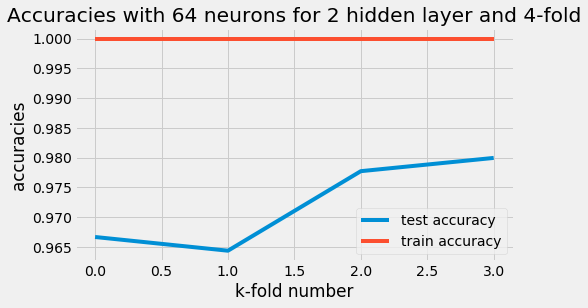

In [9]:
#visualizing
plt.style.use('fivethirtyeight')
x= range(0,4)
y_test= test_accuracies
y_train= train_accuracies
fig,ax= plt.subplots(figsize=(7,4))
ax.plot(x,y_test, label='test accuracy')
ax.plot(x,y_train, label='train accuracy')
ax.set_xlabel("k-fold number")
ax.set_ylabel("accuracies")
ax.set_title("Accuracies with 64 neurons for 2 hidden layer and 4-fold")
ax.legend(loc="lower right")
plt.plot()

## 11. Implement Neural Network MLPClassifier with three layers

In [10]:
#creating the training function
def train(n1,n2,n3,train,target):
    nn= MLPClassifier(hidden_layer_sizes= (n1,n2,n3),max_iter= 1000)
    nn.fit(train,target)
    return nn

#creating the validation function
def cross_validate(k,n1,n2,n3,features,target):
    kf = KFold(n_splits= k, random_state=2, shuffle= True)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        nn = train(n1,n2,n3, train_features, train_target)
        train_accuracy = test(nn, train_features, train_target)
        test_accuracy = test(nn, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

#implementing
hidden_layers= [10,64,128]
train_accuracies_n= []
test_accuracies_n= []
for hl in hidden_layers:
    train_accuracies,test_accuracies= cross_validate(6,hl,hl,hl,features,target)
    train_accuracies_n.append(np.mean(train_accuracies))
    test_accuracies_n.append(np.mean(test_accuracies))
    
print(train_accuracies_n)
print(test_accuracies_n)

[0.9997773324426631, 1.0, 1.0]
[0.9410219249349684, 0.9682961724266073, 0.9783091787439613]


## 12. Verify three Layer Model Accuracy

[]

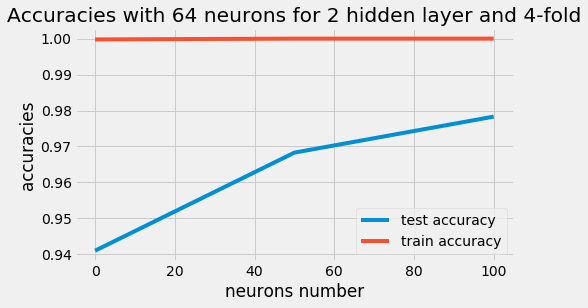

In [11]:
#visualizing
plt.style.use('fivethirtyeight')
x= range(0,150,50)
y_test= test_accuracies_n
y_train= train_accuracies_n
fig,ax= plt.subplots(figsize=(7,4))
ax.plot(x,y_test, label='test accuracy')
ax.plot(x,y_train, label='train accuracy')
ax.set_xlabel("neurons number")
ax.set_ylabel("accuracies")
ax.set_title("Accuracies with 64 neurons for 2 hidden layer and 4-fold")
ax.legend(loc="lower right")
plt.plot()

## 13. Implement Decision Trees and Random Forests

The next step will be to test the Decision Tree and Random Forests machine learning models. For each of these two models, the process will be exactly the same we have been using for the other models as well:

- build a pipeline;
- implement the model;
- visualize accuracy.

### Decision Tree Pipeline, Implementation and Accuracy Analysis


In [12]:
#creating the training function
def train(m_s_l,train,target):
    dt= DecisionTreeClassifier(min_samples_leaf= m_s_l)
    dt.fit(train,target)
    return dt

#creating the testing function
def test(dt,test,target):
    prediction= dt.predict(test)
    return accuracy_score(target,prediction)

#creating the validation function for several values of the min_samples_leaf
def cross_validate(k,m_s_l,features,target):
    kf = KFold(n_splits= k, random_state=2, shuffle= True)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        dt = train(m_s_l,train_features, train_target)
        train_accuracy = test(dt, train_features, train_target)
        test_accuracy = test(dt, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

#implementing
min_samples_leafs= [1,2,3,4,5,6,7,8,9,10]
train_accuracies_d= []
test_accuracies_d= []

for m in min_samples_leafs:
    train_accuracies,test_accuracies= cross_validate(4,m,features,target)
    train_accuracies_d.append(np.mean(train_accuracies))
    test_accuracies_d.append(np.mean(test_accuracies))
    
print(train_accuracies_d)
print(test_accuracies_d)

[1.0, 0.9673529923624099, 0.9486185093151283, 0.9369331562170248, 0.9259886790956494, 0.9148594304521092, 0.9052130352316059, 0.8987208358391766, 0.8870341059040971, 0.8798011682186373]
[0.851425389755011, 0.8425167037861916, 0.8375105171987132, 0.8291586241029448, 0.8341709972779014, 0.8291623360554319, 0.8252709725315516, 0.8197018064835436, 0.8108042563721851, 0.8147018064835436]


[]

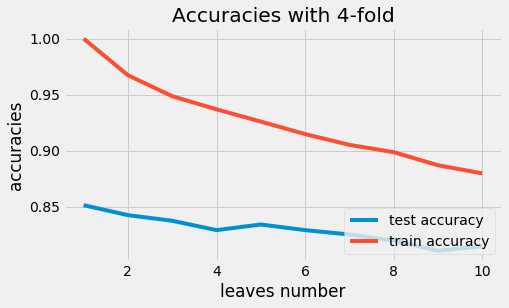

In [13]:
#visualizing
x= range(1,11)
y_test= test_accuracies_d
y_train= train_accuracies_d
fig,ax= plt.subplots(figsize=(7,4))
ax.plot(x,y_test, label='test accuracy')
ax.plot(x,y_train, label='train accuracy')
ax.set_xlabel("leaves number")
ax.set_ylabel("accuracies")
ax.set_title("Accuracies with 4-fold")
ax.legend(loc="lower right")
plt.plot()

For the Decision Tree model, even though the overfitting decreases with the increase in the minimum number of samples per leaf, the model also reduces accuracy a little bit.

### Random Forest Pipeline, Implementation and Accuracy Analysis


In [14]:
#creating the training function
def train(m_s_l,train,target):
    dt= RandomForestClassifier(min_samples_leaf= m_s_l)
    dt.fit(train,target)
    return dt

#creating the testing function
def test(rf,test,target):
    prediction= rf.predict(test)
    return accuracy_score(target,prediction)

#creating the validation function for several values of the min_samples_leaf
def cross_validate(k,m_s_l,features,target):
    kf = KFold(n_splits= k, random_state=2, shuffle= True)
    train_accuracies = []
    test_accuracies = []
    for train_index, test_index in kf.split(features):
        train_features, test_features = features.loc[train_index], features.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]

        dt = train(m_s_l,train_features, train_target)
        train_accuracy = test(dt, train_features, train_target)
        test_accuracy = test(dt, test_features, test_target)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
    
    return train_accuracies, test_accuracies

#implementing

min_samples_leafs= [1,2,3,4,5,6,7,8,9,10]
train_accuracies_d= []
test_accuracies_d= []

for m in min_samples_leafs:
    train_accuracies,test_accuracies= cross_validate(4,m,features,target)
    train_accuracies_d.append(np.mean(train_accuracies))
    test_accuracies_d.append(np.mean(test_accuracies))
    
print(train_accuracies_d)
print(test_accuracies_d)

[0.9996289424349967, 0.998330034431939, 0.9929512831019145, 0.9875723940881925, 0.982935207153384, 0.9738465685918152, 0.97384629322442, 0.9699502576337349, 0.9606749199782351, 0.9575216879360443]
[0.9465862410294481, 0.9449146250927989, 0.9493627814897302, 0.9348923533778768, 0.9443578322197476, 0.9387886661717397, 0.9226614699331849, 0.931003464488988, 0.9271096263301163, 0.9126391982182629]


[]

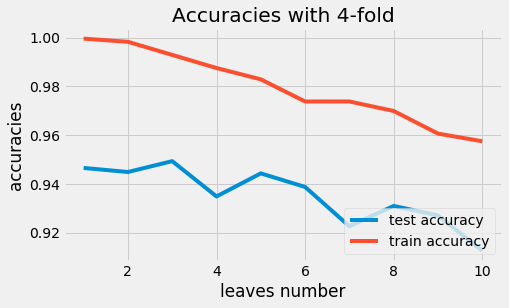

In [15]:
#visualizing
x= range(1,11)
y_test= test_accuracies_d
y_train= train_accuracies_d
fig,ax= plt.subplots(figsize=(7,4))
ax.plot(x,y_test, label='test accuracy')
ax.plot(x,y_train, label='train accuracy')
ax.set_xlabel("leaves number")
ax.set_ylabel("accuracies")
ax.set_title("Accuracies with 4-fold")
ax.legend(loc="lower right")
plt.plot()

For the Random Forest model, the result also went through overfitting decrease with the increase in the minimum number of samples per leaf and reduction in accuracy a little bit.

But it performed much better than the Decision Tree model.

## 14. Look into the Weights

Sometimes looking at the learned coefficients of a neural network can provide insight into the learning behavior. 

[This article](https://ml4a.github.io/ml4a/looking_inside_neural_nets/) to why visualizing weights and what to expect seeing. The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting.

For example, if weights look unstructured, maybe some were not used at all, or if very large coefficients exist, maybe regularization was too low or the learning rate too high. Let's look at the [visualized weights](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html). 

We will add a visualize_nn_weights function to our pipeline:


[(64, 256), (256, 256), (256, 10)]
First layer:


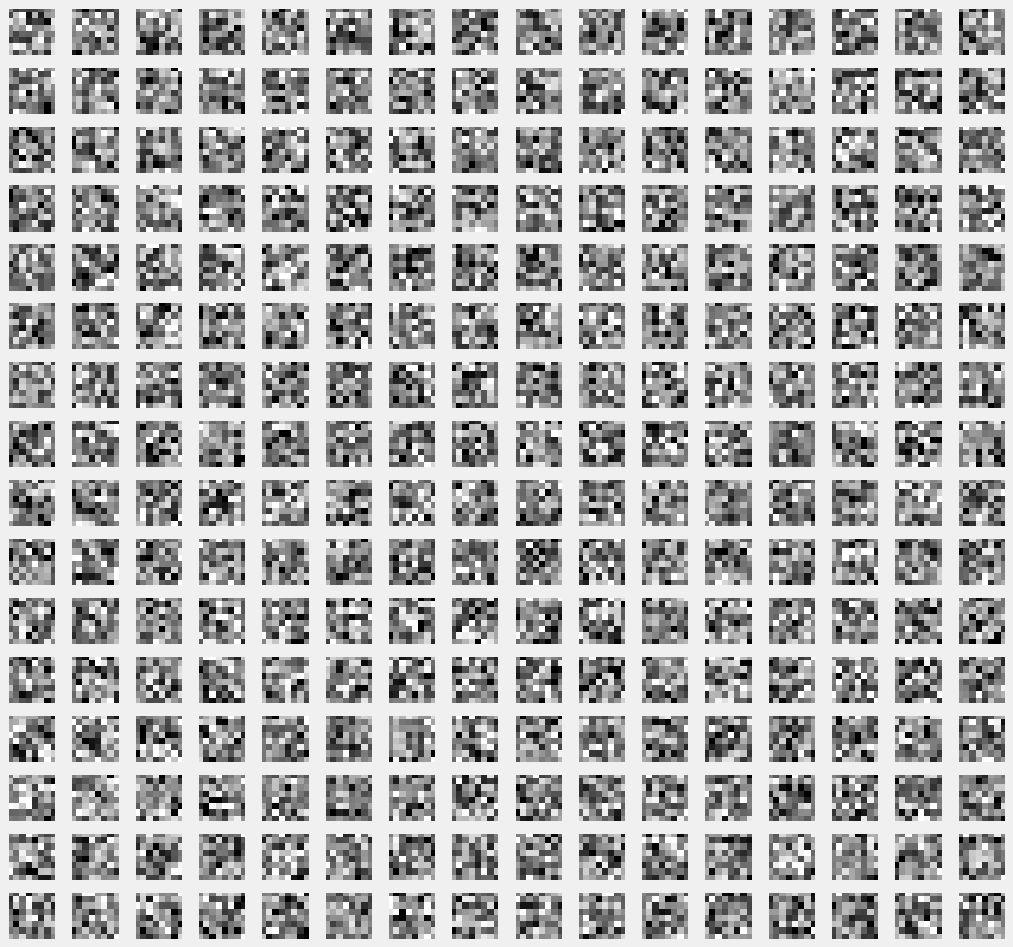

Second layer:


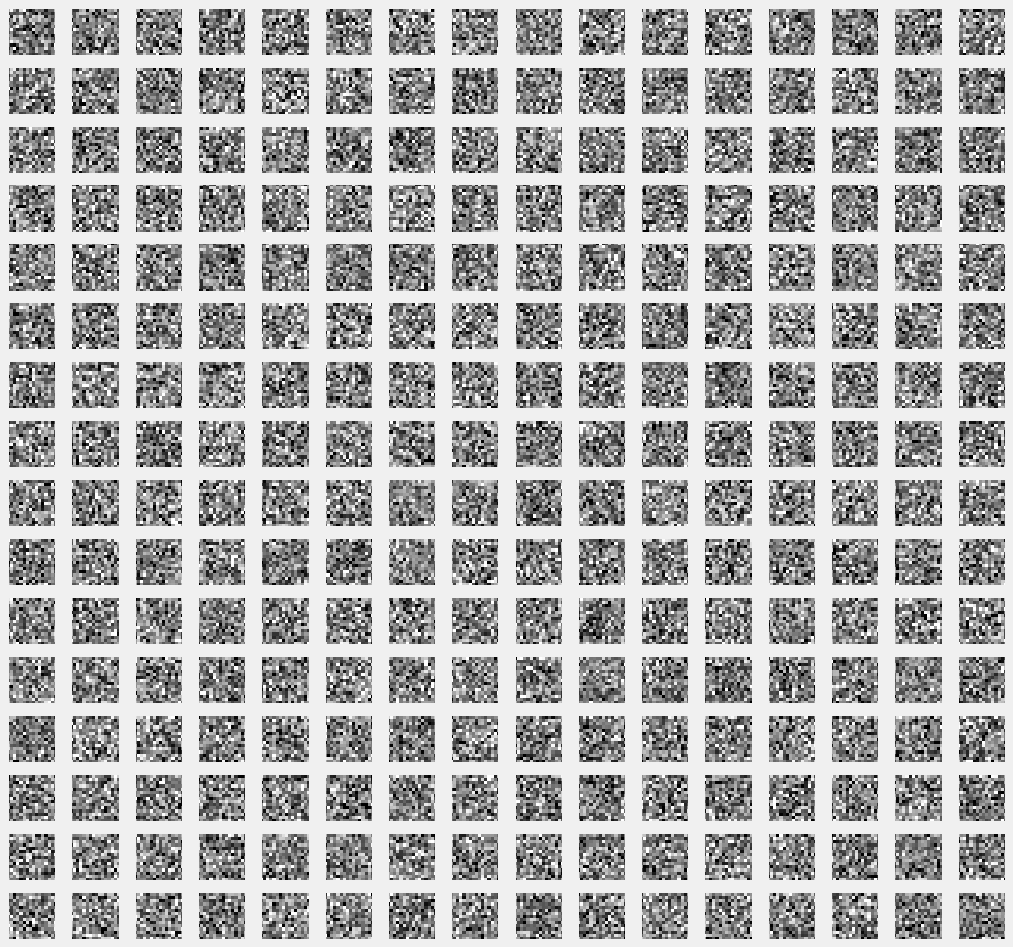

Output layer:


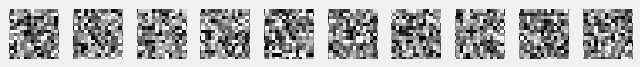

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.97,
  0.9433333333333334,
  0.97,
  0.9765886287625418,
  0.9899665551839465,
  0.919732441471572])

In [16]:
#creating the training function
def train(n,train,target):
    nn= MLPClassifier(hidden_layer_sizes= n,max_iter= 1000)
    nn.fit(train,target)
    return nn

#creating the testing function
def test(nn,test,target):
    prediction= nn.predict(test)
    return accuracy_score(target,prediction)

#creating the weight visualization function
def visualize_nn_weights(coef, X_train, y_train, X_test, y_test, layer = 0):
    row = 16
    col = 16
    fig_size = (16, 16)
    if layer ==2:
        row = 1
        col = 10
        fig_size = (10, 36)
    fig, axes = plt.subplots(row, col, figsize=fig_size)
    # use global min / max to ensure all weights are shown on the same scale
    vmin, vmax = coef[layer].min(), coef[layer].max()
    for coef, ax in zip(coef[layer].T, axes.ravel()):
        if layer == 0:
            ax.matshow(coef.reshape(8, 8), cmap=plt.cm.gray, vmin=.5 * vmin,
                       vmax=.5 * vmax)
        else:
            ax.matshow(coef.reshape(16,16), cmap=plt.cm.gray, vmin=.5 * vmin,
                       vmax=.5 * vmax)
        
        ax.set_xticks(())
        ax.set_yticks(())

    plt.show()

#creating the validation function
def cross_validate(n_neurons, df, target, nsplits = 4, layer = 0):
    kf = KFold(n_splits=nsplits, random_state=2)
    train_accuracies = []
    test_accuracies = []
    coefs = []
    for train_index, test_index in kf.split(df):
        train_features, test_features = df.loc[train_index], df.loc[test_index]
        train_target, test_target = target.loc[train_index], target.loc[test_index]
        model = train(n_neurons, train_features, train_target)        
        coefs.append(model.coefs_)
        train_accuracy = test(model, train_features, train_target)
        test_accuracy = test(model, test_features, test_target)
        train_accuracies.append(train_accuracy) 
        test_accuracies.append(test_accuracy) 
    print("")
    print([coef.shape for coef in model.coefs_])
    print("First layer:")
    visualize_nn_weights(np.mean(coefs, axis = 0), train_features, train_target, test_features, test_target, 0)
    print("Second layer:")
    visualize_nn_weights(np.mean(coefs, axis = 0), train_features, train_target, test_features, test_target, 1)
    print("Output layer:")
    visualize_nn_weights(np.mean(coefs, axis = 0), train_features, train_target, test_features, test_target, 2)
    return train_accuracies, test_accuracies
cross_validate((256, 256), features, target, 6, 1)

It is hard to identify patterns in these visualized weights. This might be a sign of overfitting according to [this article](https://cs231n.github.io/understanding-cnn/):


"The weights are useful to visualize because well-trained networks usually display nice and smooth filters without any noisy patterns. Noisy patterns can be an indicator of a network that hasn’t been trained for long enough, or possibly a very low regularization strength that may have led to overfitting."

## 15. Conclusions and Next Steps


The following were the best performing models:

- K-Nearest Neighbors;
- single layer MLPClassifier with ReLU activation function;
- 250 neurons the three layer MLPClassifier.

### Here are some next steps to try:

- Experiment with different activation functions to see if the accuracies improve.
- Research some techniques for visualizing weights in neural network models and add a visualization step to your pipeline.
- Visualization of MLP Weights on MNIST
